In [15]:
#importing libraries and dataset
import pandas as pd
import requests
import io

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv", index_col='Month')

df.head()

,Sales
Month,
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946


In [23]:
pd.to_datetime(df.index)

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Month', length=105, freq=None)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 1964-01 to 1972-09
Data columns (total 1 columns):
Sales    105 non-null int64
dtypes: int64(1)
memory usage: 1.6+ KB


In [79]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [25]:
#creating a timeseries using sales and dates
ts = pd.Series(df['Sales'].values, index=datetime)

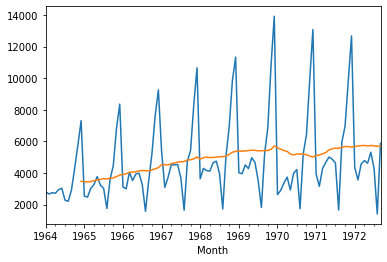

In [27]:
import matplotlib.pyplot as plt
#a quick look for patterns:
ts.plot()
ts_rolling = ts.rolling(window=12).mean()
ts_rolling.plot()
plt.show()

It's clear that there is major seasonality and irregularity. The 12 month rolling average would come in handy with the execption of June and December. 

**The weighted rolling mean**

A drawback of the rolling mean approach is that the window has to be strictly defined. In this case, we can take yearly averages but in complex situations like forecasting a stock price, it may be difficult to come up with an exact number. So we take a "weighted rolling mean" (or weighted moving average, WMA for short) where more recent values are given a higher weight. There are several techniques for assigning weights.

A popular one is Exponentially Weighted Moving Average where weights are assigned to all the previous values with an exponential decay factor. This can be implemented in Pandas with .ewm() method.

In [28]:
ts_ewm = ts.ewm(span=12)
help(ts_ewm)

Help on EWM in module pandas.core.window object:

class EWM(_Rolling)
 |  Provide exponential weighted functions.
 |  
 |  .. versionadded:: 0.18.0
 |  
 |  Parameters
 |  ----------
 |  com : float, optional
 |      Specify decay in terms of center of mass,
 |      :math:`\alpha = 1 / (1 + com),\text{ for } com \geq 0`.
 |  span : float, optional
 |      Specify decay in terms of span,
 |      :math:`\alpha = 2 / (span + 1),\text{ for } span \geq 1`.
 |  halflife : float, optional
 |      Specify decay in terms of half-life,
 |      :math:`\alpha = 1 - exp(log(0.5) / halflife),\text{for} halflife > 0`.
 |  alpha : float, optional
 |      Specify smoothing factor :math:`\alpha` directly,
 |      :math:`0 < \alpha \leq 1`.
 |  
 |      .. versionadded:: 0.18.0
 |  
 |  min_periods : int, default 0
 |      Minimum number of observations in window required to have a value
 |      (otherwise result is NA).
 |  adjust : bool, default True
 |      Divide by decaying adjustment factor in begi

In [29]:
#function to evaluate stationarity
def stationarity_check(df):
    from statsmodels.tsa.stattools import adfuller
    import matplotlib.pyplot as plt
    %matplotlib inline
  
    
    #calculate the rolling mean and std
    roll_mean = df.rolling(window=8, center=False).mean()
    roll_std = df.rolling(window=8, center=False).std()
    
    #visualizing
    fig = plt.figure(figsize = (12,8));
    plt.plot(df, color='b', label='Original')
    plt.plot(roll_mean, color='r', label='Rolling Mean')
    plt.plot(roll_std, color='g', label='Standard Deviation')
    plt.title('Rolling Mean and STD')
    plt.legend()
    plt.show()
   
    
    #Testing
    dftest = adfuller(df)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print ('Results of Dickey-Fuller test: \n')
    print(dfoutput)

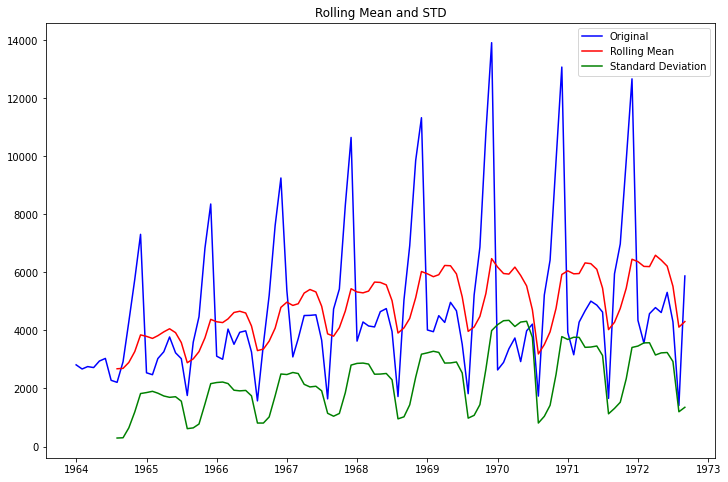

Results of Dickey-Fuller test: 

Test Statistic                 -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [30]:
stationarity_check(ts)

In [31]:
## Simpler Version of ADfullter func
def adfuller_test_df(ts):
    """Returns a DataFrame of ADFuller stationary test results."""
    from statsmodels.tsa.stattools import adfuller
    df_res = adfuller(ts)
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])
adfuller_test_df(ts)

,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.833593,0.363916,11,93,False


tests the null hypothesis that a **unit root** is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

In [32]:
ts.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Month', length=105, freq=None)

## EDA and Decomposition:

Looking to see how data is distributed:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002827C7D5198>]],
      dtype=object)

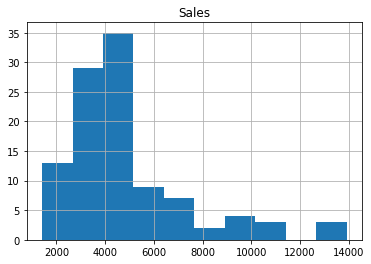

In [33]:
df.hist() 

non-normal distribution... can it be normalized with log-transformation?

(array([ 7.,  2.,  7., 18., 25., 24.,  8.,  4.,  6.,  4.]),
 array([7.25347038, 7.4822028 , 7.71093521, 7.93966763, 8.16840004,
        8.39713246, 8.62586487, 8.85459729, 9.08332971, 9.31206212,
        9.54079454]),
 <a list of 10 Patch objects>)

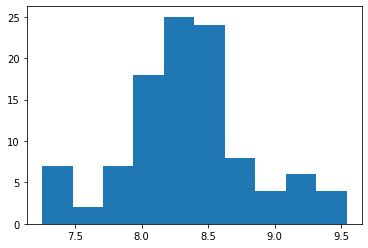

In [34]:
x= df.values
X = np.log(x)
plt.hist(X)


yup

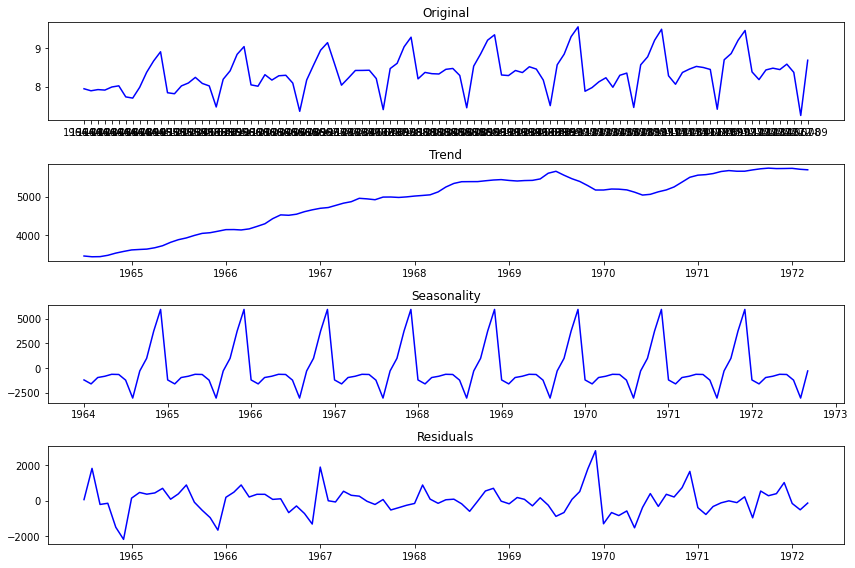

In [37]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

feats = (np.log(df), trend, seasonal, residual)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,8))

ax[0].plot(np.log(df), color='blue')
ax[0].set_title('Original')
ax[1].plot(trend, color='blue')
ax[1].set_title('Trend')
ax[2].plot(seasonal, color='blue')
ax[2].set_title('Seasonality')
ax[3].plot(residual, color='blue')
ax[3].set_title('Residuals')

plt.tight_layout()

In [38]:
len(df.values)

105

In [39]:
# discovering the mean and variance:
split = round(len(X) / 2 -.5) #105 is odd
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8.243418, mean2=8.453150
variance1=0.173122, variance2=0.262389


In [40]:
df_copy = df.copy()

In [41]:
df_copy['Sales_log'] = np.log(df['Sales'])

In [42]:
df_copy.drop('Sales', axis=1, inplace=True)

In [43]:
#converting df to Series
df_log = df_copy.squeeze()

In [45]:
df_log.isna().sum()

0

In [46]:
type(df_log)

pandas.core.series.Series

In [47]:
adfuller_test_df(df_log)

,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-2.255119,0.186852,13,91,False


In [49]:
df_diff = df.copy()

In [50]:
df_diff['Sales_diff'] = df['Sales'].diff()

In [51]:
df_diff.drop('Sales', axis=1, inplace=True)

In [52]:
df_diff = df_diff.squeeze()

In [53]:
df_diff = df_diff.dropna()

In [54]:
adfuller_test_df(df_diff)

,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-7.189896,2.519620e-10,11,92,True


;gotta be an easier way....

C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.sta

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002827C8D10F0>,
      dtype=object)

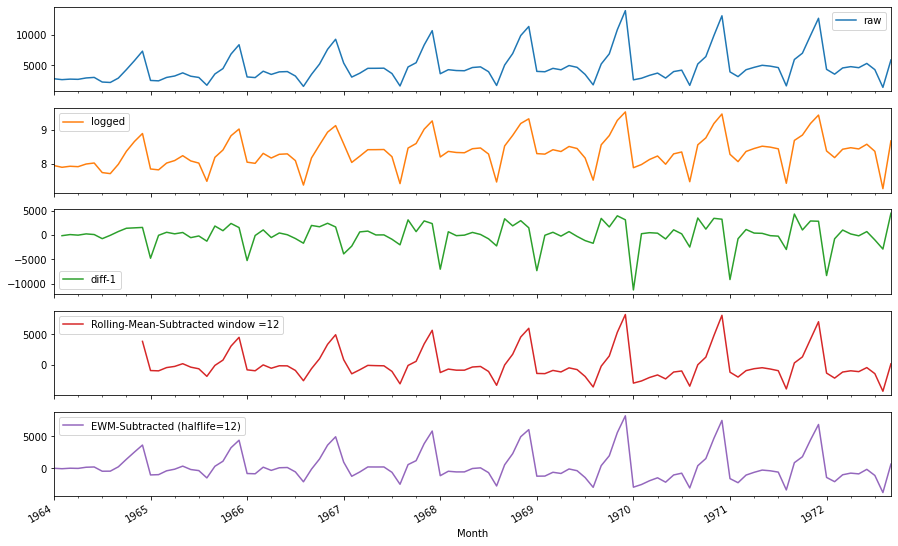

In [55]:
TS = ts.copy()
DF = pd.DataFrame()
DF['raw'] = TS

DF['logged']  =np.log(TS)

DF['diff-1'] = TS.diff(1)

DF['Rolling-Mean-Subtracted window =12'] = TS - TS.rolling(12).mean()

DF['EWM-Subtracted (halflife=12)'] = TS - TS.ewm(halflife=12).mean()

DF.plot(subplots=True,figsize=(15,10))

In [56]:
## Get stationary results for each ts
stationary_res = {}
for col in DF.columns:
    stationary_res[col] = adfuller_test_df(DF[col].bfill())

In [57]:

## concatenate results 
res = pd.concat(stationary_res)
res.index = [x[0] for x in res.index]
res


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
raw,-1.833593,3.639158e-01,11,93,False
logged,-2.255119,1.868517e-01,13,91,False
diff-1,-9.012140,6.085300e-15,11,93,True
Rolling-Mean-Subtracted window =12,-5.063782,1.657058e-05,12,92,True
EWM-Subtracted (halflife=12),-1.646436,4.588999e-01,12,92,False


C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.sta

,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
1,NaN,NaN,0,104,False
3,-7.031526,6.167582e-10,11,93,True
6,-4.126532,8.752121e-04,12,92,True


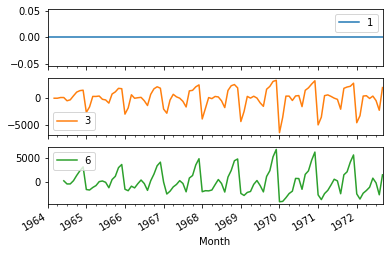

In [58]:

df_window = pd.DataFrame()
for window in [1,3,6]:
    df_window[window] = ts - ts.rolling(window=window).mean()
    
df_window.plot(subplots=True)
## Get stationary results for each ts
stationary_res = {}
for col in df_window.columns:
    stationary_res[col] = adfuller_test_df(df_window[col].bfill())
## concatenate results 
res = pd.concat(stationary_res)
res.index = [x[0] for x in res.index]
res

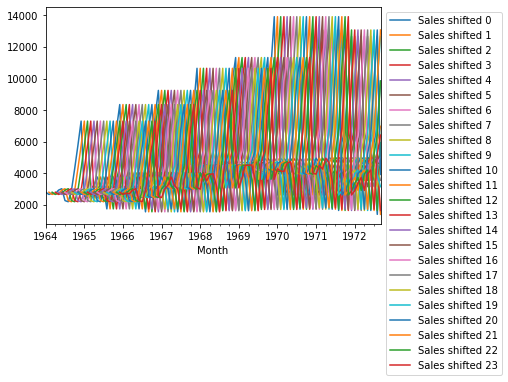

In [61]:
## Generate 6 time-shifted columns
total_shifts = 24
shifts = [ts.shift(x).rename(f"Sales shifted {x}") for x in range(total_shifts)]
res = pd.concat(shifts,axis=1)
res.plot().legend(bbox_to_anchor=(1,1))

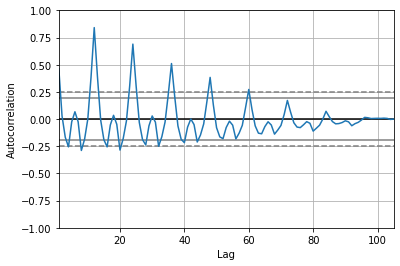

In [62]:
pd.plotting.autocorrelation_plot(ts)

In [63]:
from statsmodels.graphics.tsaplots import plot_acf

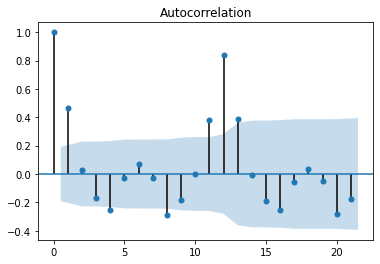

In [64]:
plot_acf(ts)
plt.show()

In [65]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


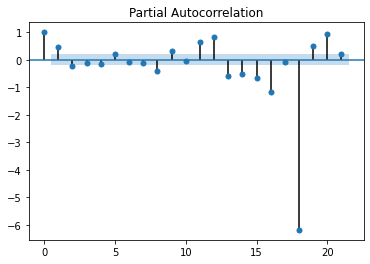

In [66]:
plot_pacf(ts)
plt.show()

In [67]:
total_shifts = 36


shifts = (ts.shift(x).rename(f'Sales shifted{x}') for x in range(total_shifts))

res = pd.concat(shifts, axis=1)

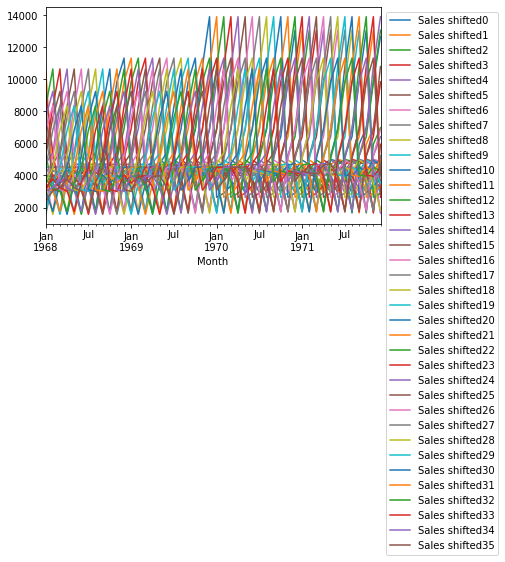

In [120]:
res.loc['1968':'1971'].plot().legend(bbox_to_anchor=(1,1))

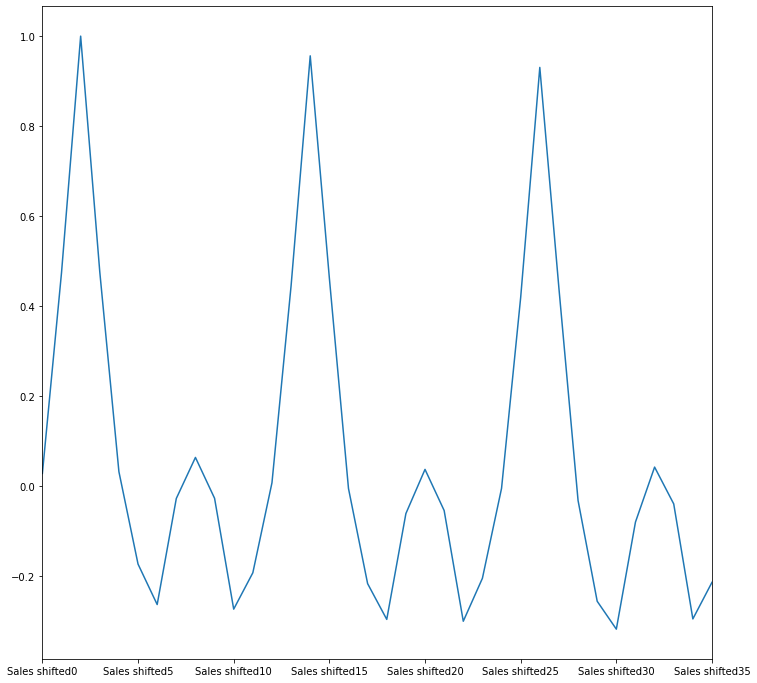

In [68]:
res.corr()['Sales shifted2'].plot(figsize=(12,12))

In [69]:
res.corr()['Sales shifted2']

Sales shifted0     0.027831
Sales shifted1     0.474130
Sales shifted2     1.000000
Sales shifted3     0.475796
Sales shifted4     0.031612
Sales shifted5    -0.173818
Sales shifted6    -0.263691
Sales shifted7    -0.027888
Sales shifted8     0.063339
Sales shifted9    -0.027455
Sales shifted10   -0.273901
Sales shifted11   -0.193082
Sales shifted12    0.006993
Sales shifted13    0.445140
Sales shifted14    0.956171
Sales shifted15    0.462190
Sales shifted16   -0.005730
Sales shifted17   -0.217239
Sales shifted18   -0.296727
Sales shifted19   -0.061492
Sales shifted20    0.036768
Sales shifted21   -0.054659
Sales shifted22   -0.300828
Sales shifted23   -0.205355
Sales shifted24   -0.005454
Sales shifted25    0.419000
Sales shifted26    0.930441
Sales shifted27    0.439047
Sales shifted28   -0.032478
Sales shifted29   -0.256414
Sales shifted30   -0.318406
Sales shifted31   -0.080343
Sales shifted32    0.041896
Sales shifted33   -0.039987
Sales shifted34   -0.295665
Sales shifted35   -0

In [70]:

import pmdarima

  ERROR: Could not find a version that satisfies the requirement pdarima (from versions: none)
ERROR: No matching distribution found for pdarima


In [71]:
import statsmodels.api as sm

In [72]:
from sklearn.model_selection import GridSearchCV

In [93]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [95]:
ts.isna().sum()

0

In [98]:
ts.index = pd.DatetimeIndex(ts.index.values,
                               freq=ts.index.inferred_freq)

In [100]:
ts.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', length=105, freq='MS')

In [ ]:
import itertools

ans = [['pdq', 'PDQ', 'aic']]

#set parameter range
p = range(0,2)
q = range(0,2)
d = range(0,)
m = [2,6,12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, m))

# SARIMA model pipeline
for param in pdq:
    for params in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts, order=param,
                                            seasonal_order=params, 
                                            enforce_invertibility=False,
                                            enforce_stationarity=False)
            results = mod.fit(max_iter=30, method='powell')
            
            ans.append(param, params, results.aic)
            #print(f'SARIMA{param},{params} - AIC:{results.aic}')
        except:
            continue

pd.DataFrame(ans[1:], columns=ans[0])

In [153]:



model = sm.tsa.statespace.SARIMAX(ts, order=(0,1,12))

grid_clf = GridSearchCV(model, param_grid, cv=7)

grid_clf

C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


GridSearchCV(cv=7, error_score=nan,
             estimator=<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001A214208940>,
             iid='deprecated', n_jobs=None,
             param_grid={'D': [3, 6, 12], 'P': [3, 6, 12], 'Q': [3, 6, 12],
                         'd': [3, 6, 12], 'm': [2, 6, 12], 'p': [3, 6, 12],
                         'q': [3, 6, 12]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:

## Set up param grid
param_grid = {'p':[3,6,12],
             'd':[3,6,12],
             'q':[3,6,12],
             'P':[3,6,12],
             'D':[3,6,12],
             'Q':[3,6,12],
             'm':[2,6,12]}

In [162]:
model.observed_information_matrix

<bound method MLEModel.observed_information_matrix of <statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001A214208940>>

In [158]:
print(f'The best parameters via GridSearchCV: {grid_clf.best_params_}')

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'